In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import entropy
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim

SEED = 16
np.random.seed(SEED)

data=np.load("../datasets/labeled/first_batch_multi_labels.npz")
data2=np.load("../datasets/labeled/second_batch_multi_labels.npz")

X1=data["X"]
y1=data["y"]

X2=data2["X"]
y2=data2["y"]

X=np.concatenate((X1,X2),axis=0)
y=np.concatenate((y1,y2),axis=0)


# X=data["X"]
# y=data["y"]
XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
yy.rename(columns={0:"user",1:"label"},inplace=True)

In [2]:
# Merge labels into main dataset
XX = XX.merge(yy, on="user", how="left")

print(XX.shape)
XX.head()

(349560, 4)


,user,item,rating,label
0,824,33,1,0
1,824,35,10,0
2,824,39,10,0
3,824,40,10,0
4,824,44,1,0


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

EPS = 1e-6

def engineer_features(XX, yy):
    user_features = XX.groupby("user").agg(
        review_count=("rating", "count"),
        avg_rating=("rating", "mean"),
        std_rating=("rating", "std"),
        like_count=("rating", lambda x: (x == 10).sum()),
        dislike_count=("rating", lambda x: (x == -10).sum()),
        unknown_count=("rating", lambda x: (x == 1).sum()),
        neutral_count=("rating", lambda x: (x == 0).sum()),
    ).reset_index()
    
    # --- PROPORTIONAL FEATURES ---
    user_features["like_pct"] = user_features["like_count"] / (user_features["review_count"] + EPS)
    user_features["dislike_pct"] = user_features["dislike_count"] / (user_features["review_count"] + EPS)
    user_features["unknown_pct"] = user_features["unknown_count"] / (user_features["review_count"] + EPS)
    user_features["neutral_pct"] = user_features["neutral_count"] / (user_features["review_count"] + EPS)
    
    # --- RATING DISTRIBUTION ENTROPY ---
    def calc_entropy(row):
        probs = [
            row["like_pct"], 
            row["dislike_pct"], 
            row["unknown_pct"], 
            row["neutral_pct"]
        ]
        probs = [p for p in probs if p > 0]  # Remove zeros
        return entropy(probs) if probs else 0
    
    user_features["rating_entropy"] = user_features.apply(calc_entropy, axis=1)
    
    # --- MOVIE POPULARITY FEATURES ---
    # Calculate movie popularity (number of ratings per movie)
    movie_popularity = XX.groupby("item").size().reset_index(name="movie_popularity")
    
    # Merge popularity with original data
    XX_with_pop = XX.merge(movie_popularity, on="item")
    
    # Calculate popularity statistics per user
    pop_features = XX_with_pop.groupby("user").agg(
        avg_movie_popularity=("movie_popularity", "mean"),
        std_movie_popularity=("movie_popularity", "std"),
        min_movie_popularity=("movie_popularity", "min"),
        max_movie_popularity=("movie_popularity", "max"),
    ).reset_index()

    # Define movie popularity percentiles
    movie_popularity = XX['item'].value_counts().reset_index()
    movie_popularity.columns = ['item', 'popularity']
    threshold = movie_popularity['popularity'].quantile(0.1)
    rare_movies = movie_popularity[movie_popularity['popularity'] <= threshold]['item'].values
    
    XX['is_rare_movie'] = XX['item'].isin(rare_movies).astype(int)
    
    rare_stats = XX.groupby('user')['is_rare_movie'].mean().reset_index(name='rare_movies_watched_pct')
    user_features = user_features.merge(rare_stats, on='user', how='left')
    
    # --- UNIQUE MOVIES AND DIVERSITY ---
    unique_items = XX.groupby("user")["item"].nunique().reset_index()
    unique_items.columns = ["user", "unique_movies"]
    
    # --- DEVIATION FROM POPULATION FEATURES ---
    # Calculate average rating per movie across all users
    movie_avg_rating = XX.groupby("item")["rating"].mean().reset_index(name="movie_avg_rating")
    
    # Join with original data
    XX_with_avg = XX.merge(movie_avg_rating, on="item")
    
    # Calculate deviation from average for each rating
    XX_with_avg["rating_deviation"] = XX_with_avg["rating"] - XX_with_avg["movie_avg_rating"]
    XX_with_avg["abs_rating_deviation"] = np.abs(XX_with_avg["rating_deviation"])

    # Calculate deviation statistics per user
    deviation_features = XX_with_avg.groupby("user").agg(
        mean_deviation=("rating_deviation", "mean"),
        std_deviation=("rating_deviation", "std"),
        mean_abs_deviation=("abs_rating_deviation", "mean"),
        max_abs_deviation=("abs_rating_deviation", "max"),
    ).reset_index()
    
    # --- SEQUENTIAL PATTERN FEATURES ---
    # Sort by user (and item as a proxy for time if no timestamp available)
    XX_sorted = XX.sort_values(["user", "item"])
    
    # Calculate differences between consecutive ratings
    XX_sorted["next_rating"] = XX_sorted.groupby("user")["rating"].shift(-1)
    XX_sorted["rating_diff"] = XX_sorted["next_rating"] - XX_sorted["rating"]
    XX_sorted["abs_rating_diff"] = np.abs(XX_sorted["rating_diff"])
    
    # Filter out NaN values (last row for each user)
    XX_sorted = XX_sorted.dropna(subset=["rating_diff"])

    XX_sorted["rating_direction"] = XX_sorted["rating_diff"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    XX_sorted['direction_switch'] = XX_sorted['rating_direction'] != XX_sorted.groupby("user")['rating_direction'].shift(1)
    switch_count = XX_sorted.groupby("user")["direction_switch"].sum().reset_index(name="change_direction_count")
    user_features = user_features.merge(switch_count, on="user", how="left")

    # Calculate sequence statistics per user
    sequence_features = XX_sorted.groupby("user").agg(
        mean_rating_diff=("rating_diff", "mean"),
        std_rating_diff=("rating_diff", "std"),
        mean_abs_rating_diff=("abs_rating_diff", "mean"),
        max_abs_rating_diff=("abs_rating_diff", "max"),
        rating_changes_count=("rating_diff", lambda x: (x != 0).sum()),
    ).reset_index()
    
    # Calculate rating changes percentage
    sequence_features["rating_changes_pct"] = sequence_features["rating_changes_count"] / (
        user_features.set_index("user")["review_count"] - 1 + EPS
    ).reindex(sequence_features["user"]).values
    
    
    # --- COMBINE ALL USER-LEVEL FEATURES ---
    all_features = user_features.merge(pop_features, on="user", how="left")
    all_features = all_features.merge(unique_items, on="user", how="left")
    all_features = all_features.merge(deviation_features, on="user", how="left")
    all_features = all_features.merge(sequence_features, on="user", how="left")
    
    # Fill any NaN values
    all_features = all_features.fillna(0)
    
    # --- UNSUPERVISED ANOMALY DETECTION FEATURES ---
    # Select numerical features for anomaly detection
    feature_cols = [col for col in all_features.columns 
                   if col not in ["user", "label", "is_anomalous"] 
                   and all_features[col].dtype in [np.float64, np.int64]]
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(all_features[feature_cols])
    
    # --- COMBINE WITH CLASS LABELS ---
    # Merge labels
    all_features = all_features.merge(yy, on="user", how="left")
    
    # Create a binary flag for anomalies
    all_features["is_anomalous"] = (all_features["label"] != 0).astype(int)
    
    # --- ADVANCED INTERACTION FEATURES ---
    # Add interaction features that might help distinguish anomaly types
    all_features["like_dislike_ratio"] = all_features["like_count"] / (all_features["dislike_count"] + EPS)
    all_features["rating_range"] = all_features["max_abs_rating_diff"]
    all_features["popularity_vs_deviation"] = all_features["avg_movie_popularity"] * all_features["mean_abs_deviation"]
    all_features["entropy_by_count"] = all_features["rating_entropy"] * np.log1p(all_features["review_count"])
    
    # --- BINNING FEATURES ---
    # Create bins for review count (might help identify certain anomaly patterns)
    all_features["review_count_bin"] = pd.qcut(all_features["review_count"], 
                                             q=5, labels=False, duplicates="drop")
    
    return all_features

# Call the function to create the features
user_features = engineer_features(XX, yy)

In [4]:
# Compute the minimum and maximum movie IDs for each user
min_max_df = XX.groupby("user")["item"].agg(min_movie="min", max_movie="max", median_movie="median", variance_movie="var").reset_index()

# Assuming 'user_features' is already computed from your original dataset
user_features = user_features.merge(min_max_df, on="user", how="left")

# Compute a new column that is the product of item and rating for each row
XX["item_rating"] = XX["item"] * XX["rating"]

sum_rating = XX.groupby("user")["rating"].sum().reset_index(name="sum_rating")

# Group by user and sum the product
sum_product = XX.groupby("user")["item_rating"].sum().reset_index(name="sum_item_rating")

# If you have an aggregated DataFrame (user_features), you can merge this in:
user_features = user_features.merge(sum_product, on="user", how="left")
user_features = user_features.merge(sum_rating, on="user", how="left")

user_features["average_product"] = user_features["sum_item_rating"] / (user_features["review_count"])

user_features["product_above_zero"] = (user_features["sum_item_rating"] > 0).astype(int)
user_features["sum_above_zero"] = (user_features["sum_rating"] > 0).astype(int)
user_features["avg_product_vs_avg_rating"] = user_features["average_product"] / (user_features["avg_rating"] + EPS)

# --- Round ratio columns to 2 decimals ---
ratio_cols = [col for col in user_features.columns if col.endswith("_ratio")]
for c in ratio_cols:
    user_features[c] = user_features[c].round(2)

XX_sorted = XX.sort_values(by=['user', 'item'])
XX_sorted['item_diff'] = XX_sorted.groupby('user')['item'].diff().fillna(0)
gap_stats = XX_sorted.groupby('user')['item_diff'].agg(['mean', 'std', 'max'])
gap_stats.columns = ['gap_mean', 'gap_std', 'gap_max']
user_features = user_features.merge(gap_stats, on='user', how='left')

# Final preview
print(user_features.shape)
#user_features.to_csv("user_features.csv", index=False)
user_features.head()


(2200, 50)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,variance_movie,sum_item_rating,sum_rating,average_product,product_above_zero,sum_above_zero,avg_product_vs_avg_rating,gap_mean,gap_std,gap_max
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,53415.140576,348353,999,2073.529762,1,1,348.701643,4.696429,4.506494,25.0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,40799.608115,234468,657,1127.250000,1,1,356.876599,3.673077,3.486183,21.0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,67011.127412,63898,200,327.682051,1,1,319.489688,4.492308,4.284194,28.0
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,17024.002439,3730,44,90.975610,1,1,84.772648,10.634146,9.873591,38.0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,42841.766667,11532,41,1922.000000,1,1,281.268252,89.666667,72.024070,192.0


In [5]:
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

df = user_features.copy()
df = df.drop(columns="is_anomalous")
print(df.shape)
df.head()

(2200, 49)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,variance_movie,sum_item_rating,sum_rating,average_product,product_above_zero,sum_above_zero,avg_product_vs_avg_rating,gap_mean,gap_std,gap_max
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,53415.140576,348353,999,2073.529762,1,1,348.701643,4.696429,4.506494,25.0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,40799.608115,234468,657,1127.250000,1,1,356.876599,3.673077,3.486183,21.0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,67011.127412,63898,200,327.682051,1,1,319.489688,4.492308,4.284194,28.0
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,17024.002439,3730,44,90.975610,1,1,84.772648,10.634146,9.873591,38.0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,42841.766667,11532,41,1922.000000,1,1,281.268252,89.666667,72.024070,192.0


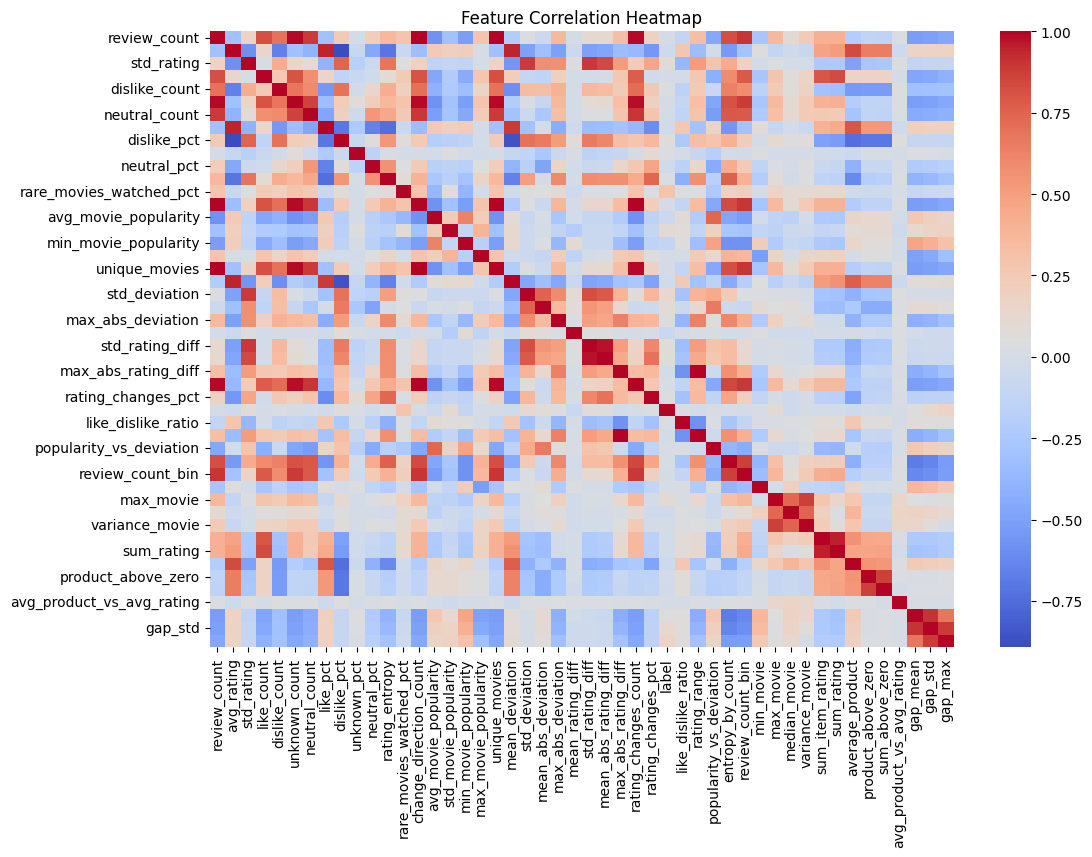

In [6]:
df.drop(columns=["user"], inplace=True, errors="ignore")
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [7]:
correlated_features = set()
threshold = 0.90

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df.drop(columns=correlated_features, inplace=True, errors="ignore")
print(f"Dropped correlated features: {correlated_features}")

Dropped correlated features: {'review_count_bin', 'mean_deviation', 'change_direction_count', 'unique_movies', 'gap_std', 'unknown_count', 'rating_changes_count', 'like_pct', 'rating_range', 'sum_rating', 'mean_abs_rating_diff'}


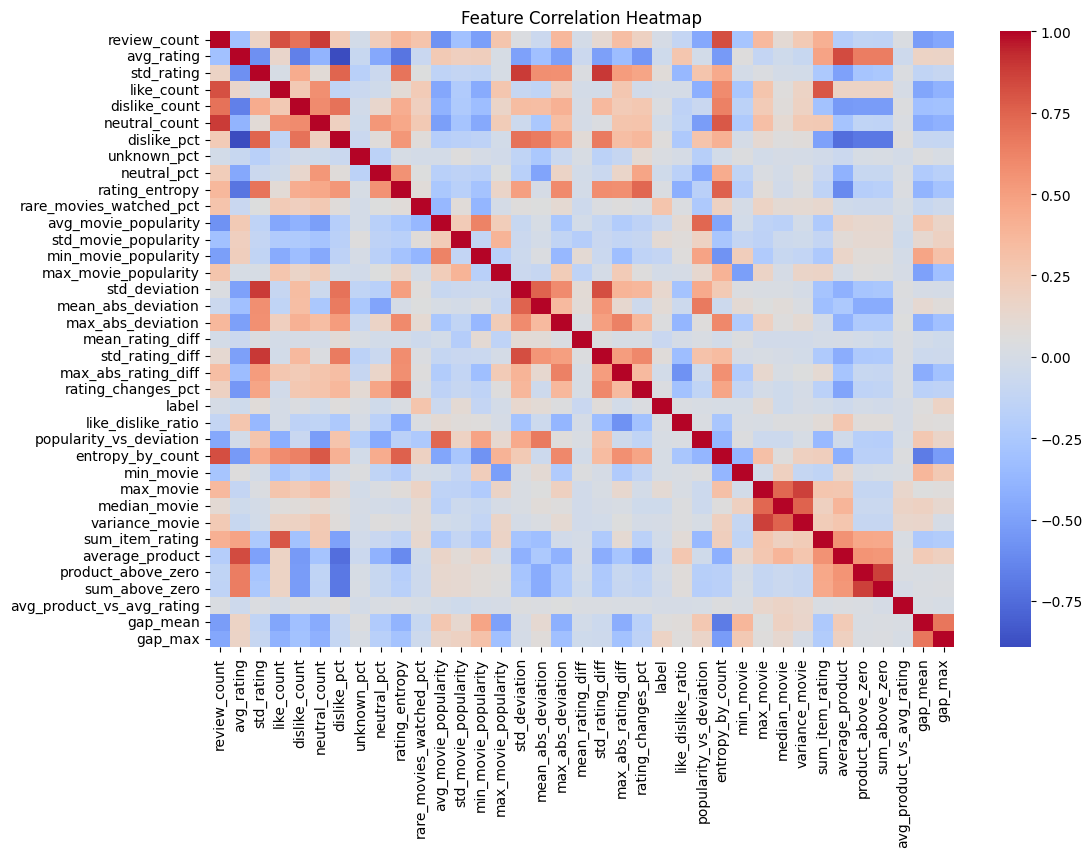

In [8]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
# Define features and target
X = df.drop(columns=["label"])
y = df["label"]

print(X.columns)
X.head()

Index(['review_count', 'avg_rating', 'std_rating', 'like_count',
       'dislike_count', 'neutral_count', 'dislike_pct', 'unknown_pct',
       'neutral_pct', 'rating_entropy', 'rare_movies_watched_pct',
       'avg_movie_popularity', 'std_movie_popularity', 'min_movie_popularity',
       'max_movie_popularity', 'std_deviation', 'mean_abs_deviation',
       'max_abs_deviation', 'mean_rating_diff', 'std_rating_diff',
       'max_abs_rating_diff', 'rating_changes_pct', 'like_dislike_ratio',
       'popularity_vs_deviation', 'entropy_by_count', 'min_movie', 'max_movie',
       'median_movie', 'variance_movie', 'sum_item_rating', 'average_product',
       'product_above_zero', 'sum_above_zero', 'avg_product_vs_avg_rating',
       'gap_mean', 'gap_max'],
      dtype='object')


,review_count,avg_rating,std_rating,like_count,dislike_count,neutral_count,dislike_pct,unknown_pct,neutral_pct,rating_entropy,...,max_movie,median_movie,variance_movie,sum_item_rating,average_product,product_above_zero,sum_above_zero,avg_product_vs_avg_rating,gap_mean,gap_max
0,168,5.946429,5.253181,100,5,14,0.029762,0.291667,0.083333,0.979856,...,798,319.5,53415.140576,348353,2073.529762,1,1,348.701643,4.696429,25.0
1,208,3.158654,5.890205,76,16,59,0.076923,0.274038,0.283654,1.277318,...,764,341.0,40799.608115,234468,1127.250000,1,1,356.876599,3.673077,21.0
2,195,1.025641,7.750913,66,52,17,0.266667,0.307692,0.087179,1.294501,...,879,400.0,67011.127412,63898,327.682051,1,1,319.489688,4.492308,28.0
3,41,1.073171,6.455193,10,7,10,0.170732,0.341463,0.243902,1.356990,...,451,247.0,17024.002439,3730,90.975610,1,1,84.772648,10.634146,38.0
4,6,6.833333,4.915960,4,0,1,0.000000,0.166667,0.166667,0.867563,...,538,386.0,42841.766667,11532,1922.000000,1,1,281.268252,89.666667,192.0


In [10]:
from imblearn.combine import SMOTETomek

print("🔹 Original Class Distribution:", Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

smote_tomek = SMOTETomek(random_state=SEED)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("🔹 Resampled Class Distribution (After SMOTE):", Counter(y_train_resampled))

poly = PolynomialFeatures(degree=1, interaction_only=False, include_bias=True)
scaler = StandardScaler()
X_train_poly = poly.fit_transform(scaler.fit_transform(X_train_resampled))
X_test_poly = poly.transform(scaler.transform(X_test))


🔹 Original Class Distribution: Counter({0: 2000, 3: 40, 4: 40, 2: 40, 5: 40, 1: 40})
🔹 Resampled Class Distribution (After SMOTE): Counter({3: 1568, 5: 1472, 4: 1437, 2: 1428, 1: 1401, 0: 1354})


In [11]:
# import optuna
# from sklearn.metrics import roc_auc_score
# import xgboost as xgb

# def objective(trial):
#     params = {
#         "objective": "multi:softprob",
#         "num_class": len(np.unique(y_train_resampled)),
#         "eval_metric": "mlogloss",
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "max_depth": trial.suggest_int("max_depth", 3, 9),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "gamma": trial.suggest_float("gamma", 0, 0.2),
#         "random_state": SEED,
#         "tree_method": "hist",
#         "predictor": "cpu_predictor",
#         "verbosity": 0,
#         "n_jobs": -1
#     }

#     model = xgb.XGBClassifier(**params)
#     model.fit(X_train_poly, y_train_resampled)
#     y_pred_proba = model.predict_proba(X_test_poly)
    
#     auc_scores = []
#     for i in range(y_pred_proba.shape[1]):
#         binary_true = (y_test == i).astype(int)
#         try:
#             auc = roc_auc_score(binary_true, y_pred_proba[:, i])
#             auc_scores.append(auc)
#         except:
#             auc_scores.append(0)
    
#     return np.mean(auc_scores)

# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
# study.optimize(objective, n_trials=65)

# best_params = study.best_params
# print("Best Parameters:", best_params)


In [12]:
import xgboost as xgb
num_classes = len(np.unique(y))
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    eval_metric='mlogloss',
    random_state=SEED,
    n_estimators=959,
    learning_rate=0.21338439089444916,
    max_depth=9,
    min_child_weight=2,
    subsample=0.8451694753137116,
    colsample_bytree=0.5639916661205568,
    gamma=0.04841076116974041,
    n_jobs=1
)

xgb_model.fit(X_train_poly, y_train_resampled)

y_pred_proba_xgb = xgb_model.predict_proba(X_test_poly)

print("XGBoost AUC Scores per Class:")
auc_per_class_xgb = {}
for i in range(y_pred_proba_xgb.shape[1]):
    binary_true = (y_test == i).astype(int)
    try:
        auc = roc_auc_score(binary_true, y_pred_proba_xgb[:, i])
        auc_per_class_xgb[i] = auc
        print(f"  Class {i}: AUC = {auc:.3f}")
    except Exception as e:
        auc_per_class_xgb[i] = None
        print(f"  Class {i}: AUC could not be computed")

k = 5
AUC_0 = auc_per_class_xgb[0]
anomaly_aucs = [auc_per_class_xgb[i] for i in range(1, k+1) if i in auc_per_class_xgb]

final_metric = (0.5 * AUC_0) + (0.5 / k) * sum(anomaly_aucs)

print(f"\nFinal Evaluation Metric: {final_metric:.3f}")

XGBoost AUC Scores per Class:
  Class 0: AUC = 0.878
  Class 1: AUC = 0.886
  Class 2: AUC = 0.863
  Class 3: AUC = 0.981
  Class 4: AUC = 0.775
  Class 5: AUC = 0.878

Final Evaluation Metric: 0.878


In [13]:
import joblib

# Save objects
model_features = list(X_train_resampled.columns)
joblib.dump(model_features, "../testing/model_features.pkl")
joblib.dump(scaler, "../testing/scaler.pkl")
joblib.dump(poly, "../testing/poly.pkl")
joblib.dump(xgb_model, "../testing/model.pkl")

['../testing/model.pkl']